In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')
import utils as ut
import plotter
import wave as w
import pickle

In [2]:
def build_assay_wave(id_, r0, D, beta, gamma=0.1, cutoff=1):
    """
    It created a wave object with a good tuning of the parameters.
    The object has to be run.
    """
    
    k = r0**2*(beta - gamma)/D
    print(k)
    dx = ut.lin_from_two_log_points(r0, 0.5, 0.1, 100, 0.6)
    dt = ut.dt_from_cfl(0.03, D, dx)
    nbins = int(ut.lin_from_two_loglog_points(r0, 0.5, 150, 100, 15000)/dx)

    p = w.Vwave_pars(id_, tot_time=ut.lin_from_two_loglog_points(r0, 0.75, 2000, 100, 30000), dt=dt, dx=dx, 
                     n_x_bins=nbins, 
                     M=5, r0=r0, D_coef=D, beta=beta, alpha=0.0, gamma=gamma,
                     Nh=10**10, N0=10**8, cutoff=cutoff,
                     t_burn=ut.lin_from_two_loglog_points(r0, 0.5, 3000, 100, 200000), 
                     t_burn_cutoff=ut.lin_from_two_loglog_points(r0, 0.5, 400, 100, 8000), 
                     back_width_fract=ut.lin_from_two_log_points(k, 2.5, 0.2, 10**6, 2),
                     traj_step=int(20/dt), check_step=int(0/dt), traj_after_burn=True, verbose=True)
    return w.Vwave(p)

In [9]:
def build_assay_wave_discr(id_, r0, D, beta, dx, gamma=0.1, cutoff=1):
    """
    It created a wave object with a good tuning of the parameters.
    The object has to be run.
    """
    
    k = r0**2*(beta - gamma)/D
    print(k)
    dx_aux = ut.lin_from_two_log_points(r0, 0.5, 0.1, 100, 0.6)
    dt = ut.dt_from_cfl(0.03, D, dx_aux)
    nbins = int(ut.lin_from_two_loglog_points(r0, 0.5, 150, 100, 15000)/dx)

    p = w.Vwave_pars(id_, tot_time=ut.lin_from_two_loglog_points(r0, 0.75, 2000, 100, 30000), dt=dt, dx=dx, 
                     n_x_bins=nbins, 
                     M=5, r0=r0, D_coef=D, beta=beta, alpha=0.0, gamma=gamma,
                     Nh=10**10, N0=10**8, cutoff=cutoff,
                     t_burn=ut.lin_from_two_loglog_points(r0, 0.5, 3000, 100, 200000), 
                     t_burn_cutoff=ut.lin_from_two_loglog_points(r0, 0.5, 400, 100, 8000), 
                     back_width_fract=ut.lin_from_two_log_points(k, 2.5, 0.2, 10**6, 2),
                     traj_step=int(20/dt), check_step=int(0/dt), traj_after_burn=True, verbose=True, use_fft=True)
    return w.Vwave(p)

### Inspecting the behavior of a single simulation
This does not produce any figure but can be useful to check the wave properties at single set of parameters

In [24]:
r0 = 5
D = 2e-3
beta = 0.12
wave = build_assay_wave_discr(0, r0, D, beta, gamma=0.1, cutoff=1, dx=1)
wave.run()

249.9999999999999
proc. 0 WARNING: dx is not small compared to r0. dx/r0= 0.2
 

Process 0:   0%|          | 0/16108 [00:00<?, ?it/s]

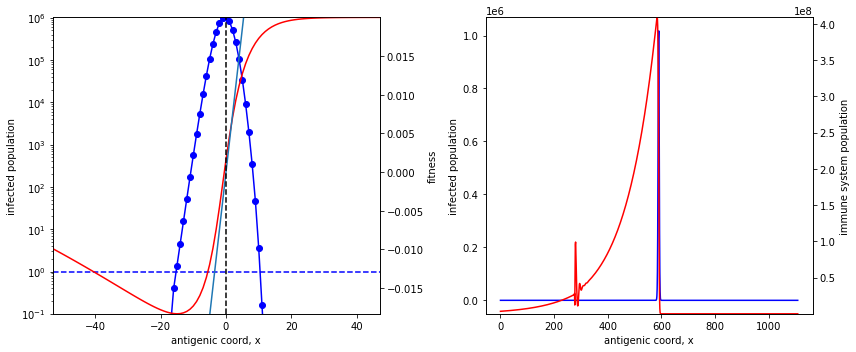

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
plotter.plot_fitness(ax1, wave)
plotter.plot_populations(ax2, wave)
plt.tight_layout()

trajectory after burning time
averaged speed: 0.012452549451706107


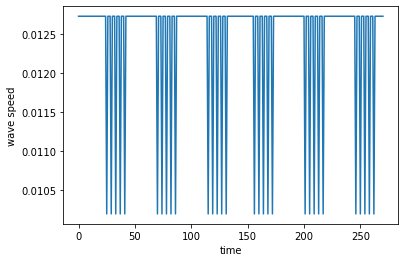

In [26]:
# Plotting the speed trajectory. Depending on the property traj_after_burn of the 
# wave object, the stored trajectory can be only after the burning time or from
# the beginning of the simulation

if wave.p.traj_after_burn:
    print('trajectory after burning time')
else:
    print('full trajectory')

plt.xlabel('time')
plt.ylabel('wave speed')
plt.plot(wave.traj.speed(20))

print('averaged speed:', np.mean(wave.traj.speed(20)))

### Computing the speed of the wave varying r0

In [10]:
r0_list = np.logspace(np.log10(0.5), np.log10(130), 20)
D = 2e-3
beta = 0.12

In [ ]:
assays = []
count = 0
for r0 in r0_list:
    assays.append(build_assay_wave(count, r0, D, beta))
    count += 1
    
#assays = ut.multiprocess_sim(assays, nproc=5)

In [ ]:
# saving the assays in a file 
f = open('data/assays.pickle', 'wb')
pickle.dump(assays, f)
f.close()

In [ ]:
# importing the assays
f = open('data/assays.pickle', 'rb')
assays = pickle.load(f)
f.close()

In [21]:
speeds = np.zeros(len(r0_list))
f_tips = np.zeros(len(r0_list))
s_tips = np.zeros(len(r0_list))
speed_lin = np.zeros(len(r0_list))
speed_FKPP = np.zeros(len(r0_list))

count = 0
for i, r in enumerate(r0_list):
    for a in assays:
        if a.p.id == count:
            speeds[i] = np.mean(a.traj.speed(20))
            f_tips[i] = np.mean(a.traj.f_tip)
            s_tips[i] = np.mean(a.traj.s_tip)
            speed_FKPP[i] = ut.speed_FKPP(a.p, 1e20, 1e-10) # No size correction here
            n = ut.size_lin(a.p, 1)
            speed_lin[i] = ut.speed_lin(a.p, n, 1)
    count+=1

In [22]:
f = open('data/det_speed.tsv', 'w')

header = '#r0\tspeed\tF_T\ts_T\tspeed_FKPP\tspeed_linfit\n'
f.write(header)

for i in range(len(r0_list)):
    f.write(str(r0_list[i]) + '\t')
    f.write(str(speeds[i]) + '\t')
    f.write(str(f_tips[i]) + '\t')
    f.write(str(s_tips[i]) + '\t')
    f.write(str(speed_FKPP[i]) + '\t')
    f.write(str(speed_lin[i]) + '\t')
    f.write('\n')
    
f.close()

In [23]:
f = open('data/det_speed_pars.tsv', 'w')

header = '#parameter\tvalue\n'
f.write(header)

f.write('D\t' + str(D) + '\n')
f.write('beta\t' + str(beta) + '\n')
f.write('alpha\t' + str(assays[0].p.alpha) + '\n')
f.write('Nh\t' + str(assays[0].p.Nh) + '\n')
f.write('M\t' + str(assays[0].p.M) + '\n')
f.write('cutoff\t' + str(assays[0].p.cutoff) + '\n')

f.close()

## Simulations with the discrete laplacian and Dx = 1

In [6]:
assays_disc = []
count = 0
for r0 in r0_list:
    assays_disc.append(build_assay_wave_discr(count, r0, D, beta, dx=1))
    count += 1
    
assays_disc = ut.multiprocess_sim(assays_disc, nproc=4)

2.4999999999999987
proc. 0 WARNING: dx is not small compared to r0. dx/r0= 2.0
6.956398505517809
proc. 1 WARNING: dx is not small compared to r0. dx/r0= 1.198968500637882
19.356592067028167
proc. 2 WARNING: dx is not small compared to r0. dx/r0= 0.7187627327609255
53.86086725079705
proc. 3 WARNING: dx is not small compared to r0. dx/r0= 0.4308869380063768
149.87106257973508
proc. 4 WARNING: dx is not small compared to r0. dx/r0= 0.25830993300297683
417.0251343000145
proc. 5 WARNING: dx is not small compared to r0. dx/r0= 0.15485273653622542
1160.3972084031936
3228.874162537204
8984.534159511557
24999.999999999978
   

Process 0:   0%|          | 0/30653 [00:00<?, ?it/s]

Process 1:   0%|          | 0/20075 [00:00<?, ?it/s]

Process 2:   0%|          | 0/16505 [00:00<?, ?it/s]

Process 3:   0%|          | 0/15417 [00:00<?, ?it/s]

Process 4:   0%|          | 0/15635 [00:00<?, ?it/s]

Process 5:   0%|          | 0/16800 [00:00<?, ?it/s]

Process 6:   0%|          | 0/18846 [00:00<?, ?it/s]

Process 7:   0%|          | 0/21857 [00:00<?, ?it/s]

Process 8:   0%|          | 0/26036 [00:00<?, ?it/s]

Process 9:   0%|          | 0/31701 [00:00<?, ?it/s]

In [7]:
speeds_disc = np.zeros(len(r0_list))
f_tips_disc = np.zeros(len(r0_list))
s_tips_disc = np.zeros(len(r0_list))
speed_lin_disc = np.zeros(len(r0_list))
speed_FKPP_disc = np.zeros(len(r0_list))

count = 0
for i, r in enumerate(r0_list):
    for a in assays_disc:
        if a.p.id == count:
            speeds_disc[i] = np.mean(a.traj.speed(20))
            f_tips_disc[i] = np.mean(a.traj.f_tip)
            s_tips_disc[i] = np.mean(a.traj.s_tip)
            speed_FKPP_disc[i] = ut.speed_FKPP(a.p, 1e20, 1e-10) # No size correction here
            n = ut.size_lin(a.p, 1)
            speed_lin_disc[i] = ut.speed_lin(a.p, n, 1)
    count+=1

In [8]:
f = open('data/det_speed_discrete_nofft.tsv', 'w')

header = '#r0\tspeed\tF_T\ts_T\tspeed_FKPP\tspeed_linfit\n'
f.write(header)

for i in range(len(r0_list)):
    f.write(str(r0_list[i]) + '\t')
    f.write(str(speeds_disc[i]) + '\t')
    f.write(str(f_tips_disc[i]) + '\t')
    f.write(str(s_tips_disc[i]) + '\t')
    f.write(str(speed_FKPP_disc[i]) + '\t')
    f.write(str(speed_lin_disc[i]) + '\t')
    f.write('\n')
    
f.close()

In [ ]:
f = open('data/discrete_speed_pars.tsv', 'w')

header = '#parameter\tvalue\n'
f.write(header)

f.write('D\t' + str(D) + '\n')
f.write('beta\t' + str(beta) + '\n')
f.write('alpha\t' + str(assays_disc[0].p.alpha) + '\n')
f.write('Nh\t' + str(assays_disc[0].p.Nh) + '\n')
f.write('M\t' + str(assays_disc[0].p.M) + '\n')
f.write('cutoff\t' + str(assays_disc[0].p.cutoff) + '\n')

f.close()

## Speed re-scaling

In [3]:
r0_list_resc = np.logspace(np.log10(1), np.log10(100), 10)
Ds = [1e-3, 2e-3]
betas = [0.12, 0.14]

In [ ]:
assay_resc = []
count = 0
for r0 in r0_list_resc:
    for D in Ds:
        for b in betas:
            assay_resc.append(build_assay_wave(count, r0, D, b))
            count += 1
    
assay_resc = ut.multiprocess_sim(assay_resc, nproc=4)

In [5]:
# saving the assays in a file 
f = open('data/assays_resc.pickle', 'wb')
pickle.dump(assay_resc, f)
f.close()

In [23]:
# importing the assays
f = open('data/assays_resc.pickle', 'rb')
assay_resc = pickle.load(f)
f.close()

In [15]:
speeds_resc = np.zeros((len(r0_list_resc),len(Ds),len(betas)))
f_tips_resc = np.zeros((len(r0_list_resc),len(Ds),len(betas)))
s_tips_resc = np.zeros((len(r0_list_resc),len(Ds),len(betas)))
speed_lin_resc = np.zeros((len(r0_list_resc),len(Ds),len(betas)))
speed_FKPP_resc = np.zeros((len(r0_list_resc),len(Ds),len(betas)))

count = 0
for i,r0 in enumerate(r0_list_resc):
    
    for j, D in enumerate(Ds):
        for k, b in enumerate(betas):
            for a in assay_resc:
                if a.p.id == count:
                    #print(a.p.id, a.p.r0, r0, a.p.D_coef, D)
                    speeds_resc[i,j,k] = np.mean(a.traj.speed(30))
                    f_tips_resc[i,j,k] = np.mean(a.traj.f_tip)
                    s_tips_resc[i,j,k] = np.mean(a.traj.s_tip)
                    speed_FKPP_resc[i,j,k] = ut.speed_FKPP(a.p, 1e20, 1e-10) # No size correction here
                    speed_lin_resc[i,j,k] = ut.speed_lin(a.p, n, 1)
            
            count+=1

In [16]:
f = open('data/rescaling_speed.tsv', 'w')

header = '#run\tr0\tspeed\tF_T\ts_T\tspeed_FKPP\tspeed_linfit\n'
f.write(header)

run = 0
for j in range(len(Ds)):
    for k in range(len(betas)):
        for i in range(len(r0_list_resc)):
            f.write(str(run) + '\t')
            f.write(str(r0_list_resc[i]) + '\t')
            f.write(str(speeds_resc[i,j,k]) + '\t')
            f.write(str(f_tips_resc[i,j,k]) + '\t')
            f.write(str(s_tips_resc[i,j,k]) + '\t')
            f.write(str(speed_FKPP_resc[i,j,k]) + '\t')
            f.write(str(speed_lin_resc[i,j,k]) + '\t')
            f.write('\n')
        run += 1

f.close()

In [17]:
f = open('data/rescaling_speed_pars.tsv', 'w')

header = '#parameter\tvalue\trun\n'
f.write(header)

run = 0
for i in range(len(Ds)):
    for j in range(len(betas)):
        for a in assay_resc:
            if a.p.id == run:
                f.write('D\t' + str(a.p.D_coef) + '\t' + str(run) + '\n')
                f.write('beta\t' + str(a.p.beta) + '\t' + str(run) + '\n')
                f.write('gamma\t' + str(a.p.gamma) + '\t' + str(run) + '\n')
                f.write('alpha\t' + str(a.p.alpha) + '\t' + str(run) + '\n')
                f.write('Nh\t' + str(a.p.Nh) + '\t' + str(run) + '\n')
                f.write('M\t' + str(a.p.M) + '\t' + str(run) + '\n')
                f.write('cutoff\t' + str(a.p.cutoff) + '\t' + str(run) + '\n')
        run += 1

f.close()

## Computing the speed at different cutoffs

In [63]:
r0_list_cutoff = np.logspace(np.log10(0.75), np.log10(80), 15)
D_cutoff = 2e-3
beta_cutoff = 0.12
cutoffs = np.logspace(np.log10(0.002),np.log10(500),3)

In [65]:
assays_cutoff = []
count = 0
for r0 in r0_list_cutoff:
    for c in cutoffs:
        assays_cutoff.append(build_assay_wave(count, r0, D_cutoff, beta_cutoff, cutoff=c))
        count += 1
    
assays_cutoff = ut.multiprocess_sim(assays_cutoff, nproc=4)

5.624999999999997
proc. 0 WARNING: dx is not small compared to r0. dx/r0= 0.18435143084836048
5.624999999999997
proc. 1 WARNING: dx is not small compared to r0. dx/r0= 0.18435143084836048
5.624999999999997
proc. 2 WARNING: dx is not small compared to r0. dx/r0= 0.18435143084836048
10.96076624526893
proc. 3 WARNING: dx is not small compared to r0. dx/r0= 0.16213071238069426
10.96076624526893
proc. 4 WARNING: dx is not small compared to r0. dx/r0= 0.16213071238069426
10.96076624526893
proc. 5 WARNING: dx is not small compared to r0. dx/r0= 0.16213071238069426
21.357937188164758
proc. 6 WARNING: dx is not small compared to r0. dx/r0= 0.13768492647510563
21.357937188164758
proc. 7 WARNING: dx is not small compared to r0. dx/r0= 0.13768492647510563
21.357937188164758
proc. 8 WARNING: dx is not small compared to r0. dx/r0= 0.13768492647510563
41.61766346677519
proc. 9 WARNING: dx is not small compared to r0. dx/r0= 0.11406373621372265
41.61766346677519
proc. 10 WARNING: dx is not small compa

Process 0:   0%|          | 0/21402 [00:00<?, ?it/s]

Process 1:   0%|          | 0/21402 [00:00<?, ?it/s]

Process 3:   0%|          | 0/18035 [00:00<?, ?it/s]

Process 2:   0%|          | 0/21402 [00:00<?, ?it/s]

Process 4:   0%|          | 0/18035 [00:00<?, ?it/s]

Process 5:   0%|          | 0/18035 [00:00<?, ?it/s]

Process 6:   0%|          | 0/16322 [00:00<?, ?it/s]

Process 7:   0%|          | 0/16322 [00:00<?, ?it/s]

Process 8:   0%|          | 0/16322 [00:00<?, ?it/s]

Process 9:   0%|          | 0/15543 [00:00<?, ?it/s]

Process 10:   0%|          | 0/15543 [00:00<?, ?it/s]

Process 11:   0%|          | 0/15543 [00:00<?, ?it/s]

Process 12:   0%|          | 0/15377 [00:00<?, ?it/s]

Process 13:   0%|          | 0/15377 [00:00<?, ?it/s]

Process 14:   0%|          | 0/15377 [00:00<?, ?it/s]

Process 15:   0%|          | 0/15674 [00:00<?, ?it/s]

Process 16:   0%|          | 0/15674 [00:00<?, ?it/s]

Process 17:   0%|          | 0/15674 [00:00<?, ?it/s]

Process 18:   0%|          | 0/16364 [00:00<?, ?it/s]

Process 19:   0%|          | 0/16364 [00:00<?, ?it/s]

Process 20:   0%|          | 0/16364 [00:00<?, ?it/s]

Process 21:   0%|          | 0/17425 [00:00<?, ?it/s]

Process 22:   0%|          | 0/17425 [00:00<?, ?it/s]

Process 23:   0%|          | 0/17425 [00:00<?, ?it/s]

Process 24:   0%|          | 0/18864 [00:00<?, ?it/s]

Process 25:   0%|          | 0/18864 [00:00<?, ?it/s]

Process 26:   0%|          | 0/18864 [00:00<?, ?it/s]

Process 27:   0%|          | 0/20712 [00:00<?, ?it/s]

Process 28:   0%|          | 0/20712 [00:00<?, ?it/s]

Process 29:   0%|          | 0/20712 [00:00<?, ?it/s]

Process 30:   0%|          | 0/23020 [00:00<?, ?it/s]

Process 31:   0%|          | 0/23020 [00:00<?, ?it/s]

Process 32:   0%|          | 0/23020 [00:00<?, ?it/s]

Process 33:   0%|          | 0/25857 [00:00<?, ?it/s]

Process 34:   0%|          | 0/25857 [00:00<?, ?it/s]

Process 35:   0%|          | 0/25857 [00:00<?, ?it/s]

Process 36:   0%|          | 0/29318 [00:00<?, ?it/s]

Process 37:   0%|          | 0/29318 [00:00<?, ?it/s]

Process 38:   0%|          | 0/29318 [00:00<?, ?it/s]

Process 39:   0%|          | 0/33518 [00:00<?, ?it/s]

Process 40:   0%|          | 0/33518 [00:00<?, ?it/s]

Process 41:   0%|          | 0/33518 [00:00<?, ?it/s]

Process 42:   0%|          | 0/38605 [00:00<?, ?it/s]

Process 43:   0%|          | 0/38605 [00:00<?, ?it/s]

Process 44:   0%|          | 0/38605 [00:00<?, ?it/s]

In [66]:
# saving the assays in a file 
f = open('data/assays_cutoff.pickle', 'wb')
pickle.dump(assays_cutoff, f)
f.close()

In [67]:
# importing the assays
f = open('data/assays_cutoff.pickle', 'rb')
assays_cutoff = pickle.load(f)
f.close()

In [68]:
speeds_cutoff = np.zeros((len(r0_list_cutoff), len(cutoffs)))
f_tips_cutoff = np.zeros((len(r0_list_cutoff), len(cutoffs)))
s_tips_cutoff = np.zeros((len(r0_list_cutoff), len(cutoffs)))
speeds_lin_cutoff = np.zeros((len(r0_list_cutoff), len(cutoffs)))
speeds_FKPP_cutoff = np.zeros((len(r0_list_cutoff), len(cutoffs)))
count = 0
for i, r in enumerate(r0_list_cutoff):
    for j, c in enumerate(cutoffs):
        for a in assays_cutoff:
            if a.p.id == count:
                speeds_cutoff[i,j] = np.mean(a.traj.speed(30))
                f_tips_cutoff[i,j] = np.mean(a.traj.f_tip)
                s_tips_cutoff[i,j] = np.mean(a.traj.s_tip)
                speeds_FKPP_cutoff[i,j] = ut.speed_FKPP(a.p, 1e20, 1e-10)
                n = ut.size_lin(a.p, c)
                speeds_lin_cutoff[i,j] = ut.speed_lin(a.p, n, c)
        count+=1

In [69]:
f = open('data/cutoff_speed.tsv', 'w')

header = '#run\tr0\tspeed\tF_T\ts_T\tspeed_FKPP\tspeed_linfit\n'
f.write(header)

run = 0
for j in range(len(cutoffs)):
    for i in range(len(r0_list_cutoff)):
        f.write(str(run) + '\t')
        f.write(str(r0_list_cutoff[i]) + '\t')
        f.write(str(speeds_cutoff[i,j]) + '\t')
        f.write(str(f_tips_cutoff[i,j]) + '\t')
        f.write(str(s_tips_cutoff[i,j]) + '\t')
        f.write(str(speeds_FKPP_cutoff[i,j]) + '\t')
        f.write(str(speeds_lin_cutoff[i,j]) + '\t')
        f.write('\n')
    run += 1

f.close()

In [70]:
f = open('data/cutoff_speed_pars.tsv', 'w')

header = '#parameter\tvalue\trun\n'
f.write(header)

run = 0
for j in range(len(cutoffs)):
    for a in assays_cutoff:
        if a.p.id == run:
            f.write('D\t' + str(a.p.D_coef) + '\t' + str(run) + '\n')
            f.write('beta\t' + str(a.p.beta) + '\t' + str(run) + '\n')
            f.write('alpha\t' + str(a.p.alpha) + '\t' + str(run) + '\n')
            f.write('Nh\t' + str(a.p.Nh) + '\t' + str(run) + '\n')
            f.write('M\t' + str(a.p.M) + '\t' + str(run) + '\n')
            f.write('cutoff\t' + str(a.p.cutoff) + '\t' + str(run) + '\n')
    run += 1

f.close()

## Computing the speed at different delta x

In [13]:
def build_assay_wave_dx(id_, r0, D, beta, Delta_x=0.5, gamma=1.0, cutoff=1):
    dx = ut.lin_from_two_points(np.log(r0/Delta_x), np.log(0.01), 0.001, np.log(1), 0.005)
    dt = ut.dt_from_cfl(0.03, D, dx)

    p = w.Vwave_pars(id_, tot_time=2000, dt=dt, dx=dx, 
                     n_x_bins=int( ut.lin_from_two_points(r0/Delta_x, 0.01, 3, 1, 50)/dx ), 
                     M=5, r0=r0, D_coef=D, beta=beta, alpha=0.0, gamma=gamma,
                     Nh=10**12, N0=10**10, cutoff=cutoff,
                     t_burn=ut.lin_from_two_points(r0/Delta_x, 0.01, 1000, 1, 15000), 
                     t_burn_cutoff=ut.lin_from_two_points(r0/Delta_x, 0.01, 70, 1, 1000), 
                     back_width_fract=ut.lin_from_two_points(np.log(r0/Delta_x), np.log(0.0075), 0.1, np.log(1), 3),
                     traj_step=int(10/dt), check_step=int(0/dt), traj_after_burn=True, verbose=True)
    return w.Vwave(p)

In [14]:
delta_xs = [0.5, 1, 2]
c_list_dx = np.logspace(np.log10(0.0075), np.log10(2), 15)
D0 = 1e-5
beta = 2

In [ ]:
assays_dx = []
count = 0
for c in c_list_dx:
    for dx in delta_xs:
        assays_dx.append(build_assay_wave_dx(count, c * dx, D0 * dx**2, beta, Delta_x=dx))
        count += 1
    
assays_dx = ut.multiprocess_sim(assays_dx, nproc=4)

In [10]:
# saving the assays in a file 
#f = open('data/assays_dx.pickle', 'wb')
#pickle.dump(assays_dx, f)
#f.close()

In [15]:
# importing the assays
f = open('data/assays_dx.pickle', 'rb')
assays_dx = pickle.load(f)
f.close()

In [ ]:
speeds_dx = np.zeros((len(c_list_dx), len(delta_xs)))
count = 0
for i, r in enumerate(c_list_dx):
    for j in range(len(delta_xs)):
        for a in assays_dx:
            if a.p.id == count:
                speeds_dx[i,j] = np.mean(a.traj.speed(50))
        count+=1

In [21]:
f = open('data/dx_speed.tsv', 'w')

header = '#run\tr0\tspeed\n'
f.write(header)

run = 0
for j in range(len(delta_xs)):
    for i in range(len(c_list_dx)):
        f.write(str(run) + '\t')
        f.write(str(c_list_dx[i]*delta_xs[j]) + '\t')
        f.write(str(speeds_dx[i,j]) + '\t')
        f.write('\n')
    run += 1

f.close()

In [22]:
f = open('data/dx_speed_pars.tsv', 'w')

header = '#parameter\tvalue\trun\n'
f.write(header)

run = 0
for j in range(len(delta_xs)):
    for a in assays_dx:
        if a.p.id == run:
            f.write('Dx\t' + str(delta_xs[j]) + '\t' + str(run) + '\n')
            f.write('D\t' + str(a.p.D_coef) + '\t' + str(run) + '\n')
            f.write('beta\t' + str(a.p.beta) + '\t' + str(run) + '\n')
            f.write('alpha\t' + str(a.p.alpha) + '\t' + str(run) + '\n')
            f.write('Nh\t' + str(a.p.Nh) + '\t' + str(run) + '\n')
            f.write('M\t' + str(a.p.M) + '\t' + str(run) + '\n')
            f.write('cutoff\t' + str(a.p.cutoff) + '\t' + str(run) + '\n')
    run += 1

f.close()